In [ ]:
## Required files:

## an Input file containing China and Montgomery Xrays, diagnoses, and masks (provided by Dr. A. through Seton Hall University Google Drive)

## The CheXpert-V1.0-small.zip file, provided by the Stanford ML group.

## If on AWS, set this variable to True

## If not running on AWS, ensure that input file is in same directory as this notebook. If you don't have the input file, you will need to download it.

## Note that the full Stanford ML file must also be downloaded separately. the dataset (CheXpert-V1.0-small.zip) from the Stanford ML group, and unzip it. A script for unzipping the files is provided below. 


In [1]:

RUNNING_ON_AWS = False

# Unzipping very large files: https://stackoverflow.com/questions/339053/how-do-you-unzip-very-large-files-in-python

In [2]:


# import errno
# import os
# import shutil
# import zipfile

# TARGETDIR = os.path.join('.')

# src = os.path.join('.', 'CheXpert-V1.0-small.zip')

# with open(src, "rb") as zipsrc:
#     zfile = zipfile.ZipFile(zipsrc)
#     for member in zfile.infolist():
#         print("Now serving member: {}".format(member))
#         target_path = os.path.join(TARGETDIR, member.filename)
#         if target_path.endswith('/'):  # folder entry, create
#             try:
#                 os.makedirs(target_path)
#             except (OSError, IOError) as err:
#                # Windows may complain if the folders already exist
#                 if err.errno != errno.EEXIST:
#                     raise
#             continue
#         with open(target_path, 'wb') as outfile, zfile.open(member) as infile:
#            shutil.copyfileobj(infile, outfile)

In [3]:
import torch
import torchvision
import os
import matplotlib.pyplot as plt
import glob
import pandas as pd



## TODO: Add Montgomery file S3 bucket info here

In [7]:
#Get all China set files:

if RUNNING_ON_AWS == True:
    import s3fs
    fs = s3fs.S3FileSystem()
    china_Files = fs.ls('s3://chexrayproject-allchinafiles')
    shen_paths = []
    for filename in glob.iglob(china_Files + "**/*", recursive=True):
        shen_paths.append(filename)
else:
    shen_dir = ".\\input\\ChinaSet_AllFiles\\ChinaSet_AllFiles\\"
    shen_paths = []
    for filename in glob.iglob(shen_dir + "**/*", recursive=True):
        shen_paths.append(filename)


#get all the Montgomery set files

if RUNNING_ON_AWS == True:
    pass
    #add AWS specific buckets for montgomery files here
    
else:
    mont_dir = ".\\input\\Montgomery\\MontgomerySet\\"
    mont_paths = []
    for filename in glob.iglob(mont_dir + "**/*", recursive=True):
         mont_paths.append(filename)

In [9]:
print('Montgomery Files', len(mont_paths))
print('Shenzhen Files', len(shen_paths))


Montgomery Files 560
Shenzhen Files 1328


In [ ]:
#### Now combine al the files into a dataframe: all_paths_df

In [10]:
all_paths_df = pd.DataFrame(dict(path = mont_paths + shen_paths))
all_paths_df['source'] = all_paths_df['path'].map(lambda x: x.split('\\')[3])
all_paths_df['file_id'] = all_paths_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
all_paths_df['patient_group']  = all_paths_df['file_id'].map(lambda x: x.split('_')[0])

all_paths_df['file_ext'] = all_paths_df['path'].map(lambda x: os.path.splitext(x)[1][1:])
all_paths_df = all_paths_df[all_paths_df.file_ext.isin(['png', 'txt'])]
all_paths_df['pulm_state']  = all_paths_df['file_id'].map(lambda x: int(x.split('_')[-1]))
all_paths_df.sample(5)

,path,source,file_id,patient_group,file_ext,pulm_state
513,.\input\Montgomery\MontgomerySet\ManualMask\ri...,MontgomerySet,MCUCXR_0166_1,MCUCXR,png,1
1010,.\input\ChinaSet_AllFiles\ChinaSet_AllFiles\Cl...,ChinaSet_AllFiles,CHNCXR_0448_1,CHNCXR,txt,1
1874,.\input\ChinaSet_AllFiles\ChinaSet_AllFiles\CX...,ChinaSet_AllFiles,CHNCXR_0650_1,CHNCXR,png,1
1299,.\input\ChinaSet_AllFiles\ChinaSet_AllFiles\CX...,ChinaSet_AllFiles,CHNCXR_0075_0,CHNCXR,png,0
1578,.\input\ChinaSet_AllFiles\ChinaSet_AllFiles\CX...,ChinaSet_AllFiles,CHNCXR_0354_1,CHNCXR,png,1


## Create Report DF

In [11]:
clean_patients_df = all_paths_df.pivot_table(index = ['patient_group', 'pulm_state', 'file_id'], 
                                             columns=['file_ext'], 
                                             values = 'path', aggfunc='first').reset_index()
clean_patients_df.sample(5)
from warnings import warn
def report_to_dict(in_path):
    with open(in_path, 'r') as f:
        all_lines = [x.strip() for x in f.read().split('\n')]
    info_dict = {}
    try:
        if "Patient's Sex" in all_lines[0]:
            info_dict['age'] = all_lines[1].split(':')[-1].strip().replace('Y', '')
            info_dict['gender'] = all_lines[0].split(':')[-1].strip()
            info_dict['report'] = ' '.join(all_lines[2:]).strip()
        else:
            info_dict['age'] = all_lines[0].split(' ')[-1].replace('yrs', '').replace('yr', '')
            info_dict['gender'] = all_lines[0].split(' ')[0].strip()
            info_dict['report'] = ' '.join(all_lines[1:]).strip()
        
        info_dict['gender'] = info_dict['gender'].upper().replace('FEMALE', 'F').replace('MALE', 'M').replace('FEMAL', 'F')[0:1]
        if 'month' in info_dict.get('age', ''):
            info_dict.pop('age') # invalid
        if 'day' in info_dict.get('age', ''):
            info_dict.pop('age') # invalid
        elif len(info_dict.get('age',''))>0:
            info_dict['age'] = float(info_dict['age'])
        else:
            info_dict.pop('age')
        return info_dict
    except Exception as e:
        print(all_lines)
        warn(str(e), RuntimeWarning)
        return {}
report_df = pd.DataFrame([dict(**report_to_dict(c_row.pop('txt')), **c_row) 
              for  _, c_row in clean_patients_df.iterrows()])
report_df.sample(5)

['male 16month', 'normal']
['male 16month', 'normal']
['female24yrs', 'normal']

<ipython-input-11-b1a9cf3aed60>:32: RuntimeWarning: 'age'
  warn(str(e), RuntimeWarning)



['male35yrs', 'PTB in the left upper field']
['male35yrs', 'Bilateral secondary PTB']
['Male , 38yrs,', 'secondary PTB in the bilateral upper and middle fields, mainly fibrous  lesions']


<ipython-input-11-b1a9cf3aed60>:32: RuntimeWarning: could not convert string to float: 'female24'
  warn(str(e), RuntimeWarning)
<ipython-input-11-b1a9cf3aed60>:32: RuntimeWarning: could not convert string to float: 'male35'
  warn(str(e), RuntimeWarning)
<ipython-input-11-b1a9cf3aed60>:32: RuntimeWarning: could not convert string to float: '38,'
  warn(str(e), RuntimeWarning)


,age,gender,report,patient_group,pulm_state,file_id,png
287,28.0,M,normal,CHNCXR,0,CHNCXR_0288_0,.\input\ChinaSet_AllFiles\ChinaSet_AllFiles\CX...
619,37.0,M,PTB in the right upper field,CHNCXR,1,CHNCXR_0620_1,.\input\ChinaSet_AllFiles\ChinaSet_AllFiles\CX...
691,48.0,M,normal,MCUCXR,0,MCUCXR_0043_0,.\input\Montgomery\MontgomerySet\CXR_png\MCUCX...
499,22.0,F,bilateral PTB,CHNCXR,1,CHNCXR_0500_1,.\input\ChinaSet_AllFiles\ChinaSet_AllFiles\CX...
778,47.0,M,persistent rt pleural peel with some interval ...,MCUCXR,1,MCUCXR_0301_1,.\input\Montgomery\MontgomerySet\CXR_png\MCUCX...


In [ ]:
## Segmentation

In [12]:
#get all the mask files
#mask_path = os.path.join("D:\\", "Documents", "Medical", "TB","Lung Segmentation","masks")
mask_path = os.path.join('.', 'input', 'masks')
#mask directory
masks = os.listdir(mask_path)


#clean it up to align with images names: Remove the .png and the _mask(from China masks)


mask_ids_temp = [fName.split(".png")[0] for fName in masks]

mask_ids = [fName.split("_mask")[0] for fName in mask_ids_temp]

#The total # of masks
mask_file_names = [os.path.join(mask_path, mask) for mask in masks]

#masks

#Total number of modified masks - China masks
check = [i for i in masks if "mask" in i]
print("Total masks that have modified names:",len(check))

## ??? There seems to be 704 masks before modification

Total mask that has modified name: 566


In [13]:
#get all the image files
image_path = os.path.join('.', 'input',"CXR_png")

#image directory
images = os.listdir(image_path)

#clean it up to align with images names: Remove the .png and the _mask(from China masks)
image_ids = [fName.split(".png")[0] for fName in images]
#mask_file_names = [fName.split("_mask")[0] for fName in mask_id]

image_file_names = [os.path.join(image_path, image) for image in images]

#The total # of images
print('Total X-ray images: ', len(image_file_names))

Total X-ray images:  800


In [14]:
#Put all the names into a dataframe for convenience
images_df = pd.DataFrame()
images_df['xrays'] = image_file_names
images_df['file_id'] = image_ids
images_df['has_mask'] = images_df['file_id'].isin(mask_ids)

images_with_masks_df = images_df[images_df['file_id'].isin(mask_ids)]

images_with_masks_df['masks'] = mask_file_names

print("There are {} x-rays with masks".format(len(images_with_masks_df)))
images_df
print("True indicates the x-ray has a mask:")
images_df['has_mask'].value_counts()

There are 704 x-rays with masks
True indicates the x-ray has a mask:


<ipython-input-14-075844446854>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  images_with_masks_df['masks'] = mask_file_names


True     704
False     96
Name: has_mask, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split
#Do a train-test split
#??? So, here we are splitting the xrays from the masks, in segmentation we are trying to predict the mask.
# We use 90% of the data for the training set.
train_x,test_x,train_y,test_y = train_test_split(images_with_masks_df['xrays'],
                                                   images_with_masks_df['masks'],test_size    = 0.1,
                                                   random_state = 42)

#size of the training set should be 90% of 704
#len(train_x)

In [16]:
#We are also going to make a validation set.
trainx,validationx,trainy,validationy = train_test_split(train_x,train_y,test_size = 0.1,random_state = 42)

#len(trainx)

In [17]:
#Put all these data sets into data frames
train_df = pd.DataFrame(index=trainx.index)
train_df['xrays'] = trainx
train_df['masks'] = trainy

test_df = pd.DataFrame(index=test_x.index)
test_df['xrays'] = test_x
test_df['masks'] = test_y

validation_df = pd.DataFrame(index=validationx.index)
validation_df['xrays'] = validationx
validation_df['masks'] = validationy

In [18]:
## Now that we have a dataframe of training and test examples, can we mask them?

## Need a train info dataframe

In [19]:
train_info_loc = os.path.join(".", "CheXpert-v1.0-small") #Need the file path to the CheXpert-V1.0-small file (this must be downloaded independently through Stanford ML)
train_file_name = "train.csv"
train_info = pd.read_csv(os.path.join(train_info_loc, train_file_name))


In [20]:
train_info.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [21]:
len(train_info)

223414

In [22]:
train_info.fillna(0, inplace=True)
train_info.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## create a new dataframe with a column for complete path and diagnostic columns of interest:


In [23]:
train_df = pd.DataFrame(index=train_info.index)
data_df = train_info.iloc[:, 5:].copy()
data_df['xrays'] = [os.path.join('.', x) for x in train_info['Path'].values]

In [24]:
data_df.head()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,xrays
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,.\CheXpert-v1.0-small/train/patient00001/study...
1,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0,.\CheXpert-v1.0-small/train/patient00002/study...
2,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,.\CheXpert-v1.0-small/train/patient00002/study...
3,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,.\CheXpert-v1.0-small/train/patient00002/study...
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.\CheXpert-v1.0-small/train/patient00003/study...


In [25]:
import pickle

#save huge dataframe to pickle
train_df.to_pickle("train_df.pkl")

## get and view file from the data_df (checking understanding of file formats)

In [26]:
rnd_xray = data_df['xrays'][354]

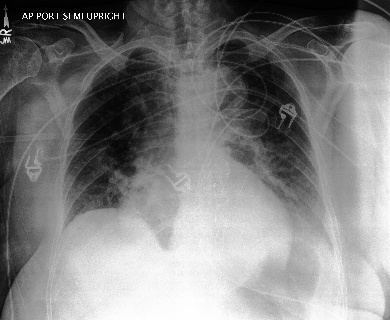

In [27]:
from PIL import Image

img = Image.open(rnd_xray) #Note, these .jpg files are PIL objects...

img

In [28]:
## Let's convert it to a tensor

from torchvision import transforms

convert_tensor = transforms.ToTensor()

img_t = convert_tensor(img)


print(img_t.shape)

shifted = img_t.permute(1, 2, 0)

print(shifted.shape)

torch.Size([1, 320, 390])
torch.Size([320, 390, 1])


In [29]:
#Create test train split

from sklearn.model_selection import GroupShuffleSplit

# Initialize the GroupShuffleSplit.
gss = GroupShuffleSplit(n_splits=1, test_size=0.01)

# Get the indexers for the split.
idx1, idx2 = next(gss.split(data_df, groups=data_df.index))

# Get the split DataFrames.
df1, df2 = data_df.iloc[idx1], data_df.iloc[idx2]



#Just use a slice of the images for now:

train_temp_df = df1.sample(100000)
test_temp_df = df2.copy()

In [30]:
train_temp_df['xrays'][432]

'.\\CheXpert-v1.0-small/train/patient00119/study5/view1_frontal.jpg'

In [31]:
len(train_temp_df)

100000

## MODEL DEVELOPMENT

## 
1) Load 1 Resnet pretrained model
2) Apply this model to data (What's the input and what's the output?)

In [ ]:
import torch.nn as nn
## Try implementing a Resnet from scratch  (tutorial here: https://www.youtube.com/watch?v=DkNIBBBvcPs)


class resblock(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample = None, stride = 1):
        super(resblock, self).__init__()
        self.expansion = 4 # "number of channels after a block is 4x what it was when it entered"
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride =1, padding = 0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride, padding =1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels *self.expansion, kernel_size =1, stride=1, padding = 0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
            
            print('SHAPES:')
            print(x.shape)
            print(identity.shape)
        
        x += identity
        x = self.relu(x)
        return x
    

class ResNet(nn.Module): # note, the layers argument corresponds to the number of resnet blocks
    def __init__(self, resblock, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        #ResNet layers
        
        self.layer1 = self._make_layer(resblock, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(resblock, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(resblock, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(resblock, layers[3], out_channels=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*4, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        print(x.shape)
        x = self.bn1(x)
        print(x.shape)
        x = self.relu(x)
        print(x.shape)
        x = self.maxpool(x)
        print(x.shape)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x
        
        
    def _make_layer(self, resblock, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels *4, kernel_size = 1,
                                                         stride = stride),
                                               nn.BatchNorm2d(out_channels*4))
        
        layers.append(resblock(self.in_channels, out_channels, identity_downsample, stride)) #changes the number of channels
        self.in_channels = out_channels * 4
        
        for i in range(num_residual_blocks - 1):
            layers.append(resblock(self.in_channels, out_channels))
            
        return nn.Sequential(*layers)
        
        

In [ ]:
#initialize resnet 50 with our parameters: 1 channel for grayscale images, 14 classes.

def ResNet50(img_channels=1, num_classes=14):
    return ResNet(resblock, [3, 4, 6, 3], img_channels, num_classes)

In [ ]:
def test():
    net = ResNet50()
    x = torch.randn(2, 1, 224, 224)
    y = net(x).to('cuda')
    print(y.shape)
    
test()

## MAYBE WE DON'T NEED TO DEVELOP OUR OWN MODELS RIGHT NOW. TRY LOADING DR. A's PreTrained Model

## TO RUN THIS CODE MAKE SURE THE h5 MODEL IS IN THE SAME DIRECTORY AS THE NOTEBOOK, OR IF ON AWS, MAKE SURE THE h5 MODEL IS IN A BUCKET.

## TODO: THIS NEEDS TO BE TRANSLATED TO PYTORCH, 

In [ ]:
loaded_model = load_model(os.path.join('.', 'CheXpert_ResNet20v1_224_multiclass_model_epochs5.h5'))

In [ ]:
#masked_test_gen.reset()
pred=model.predict_generator(masked_test_gen, steps=len(test_temp_df), verbose=1)

In [ ]:
pred_bool = []
pred_bool = [(pred[i] > 0.5) for i in range(len(pred))]

In [ ]:
predictions = [item.astype(int) for item in pred_bool]
predictions[10]

In [ ]:
columns = diag_cols
#columns should be the same order of y_col
results=pd.DataFrame(index = test_temp_df.index)
for i in range(len(columns)):
    results[columns[i]] = predictions[i]
#ordered_cols = ["Filenames"] + columns
#results=results[ordered_cols] #To get the same column order
#results.to_csv("results.csv",index=False)
results.tail()

In [ ]:
results.describe()

## TRANSFER LEARNING WORK (THIS MUST BE TRANSLATED TO PYTORCH)

In [33]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [34]:
# initialize the input image shape (224x224 pixels) along with
# the pre-processing function (this might need to be changed
# based on which model we use to classify our image)
inputShape = (224, 224)
preprocess = preprocess_input
# if we are using the InceptionV3 or Xception networks, then we
# need to set the input shape to (299x299) [rather than (224x224)]
# and use a different image processing function
#if args["model"] in ("inception", "xception"):
#	inputShape = (299, 299)
#	preprocess = preprocess_input

In [48]:
# load the input image using the Keras helper utility while ensuring
# the image is resized to `inputShape`, the required input dimensions
# for the ImageNet pre-trained network
print("[INFO] loading and pre-processing image...")

# (Nick: trying to understand what this code is doing.)
# Keras has a load_image function that loads the image and reduces its size to 224 x 224
# Torchvision will do this with a resize transformation

import torchvision.transforms as transforms

#from earlier image loading code above:
rnd_xray = data_df['xrays'][354]
from PIL import Image
img_norm = Image.open(rnd_xray) #Note, these .jpg files are PIL objects...

img_resized = transforms.Resize(size = (224, 224))(img_norm)


img_norm.show()
img_resized.show()

[INFO] loading and pre-processing image...


In [ ]:
image = load_img(data_df['xrays'].values[1], target_size = (224, 224))

image = img_to_array(image)
# our input image is now represented as a NumPy array of shape
# (inputShape[0], inputShape[1], 3) however we need to expand the
# dimension by making the shape (1, inputShape[0], inputShape[1], 3)
# so we can pass it through the network
image = np.expand_dims(image, axis=0)
# pre-process the image using the appropriate function based on the
# model that has been loaded (i.e., mean subtraction, scaling, etc.)
image = preprocess(image)

In [ ]:
# load model without classifier layers
#model = ResNet50(include_top=False, input_shape=(input_dim,input_dim,3))
#If we don't want to train the weights:
#mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
    
#Also if don't want to train particular layers:
#mark some layers as not trainable
#model.get_layer('block1_conv1').trainable = False
#model.get_layer('block1_conv2').trainable = False
#model.get_layer('block2_conv1').trainable = False
#model.get_layer('block2_conv2').trainable = False

In [ ]:
baseModel = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(299, 299, 3)))
# construct the head of the model that will be placed on top of the
# the base model

#mark loaded layers as not trainable
#for layer in baseModel.layers:
#    layer.trainable = False


headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
y = Dense(1024, activation="relu")(headModel)
#headModel = Dropout(0.5)(headModel)
output1 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output2 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output3 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output4 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output5 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output6 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output7 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output8 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output9 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output10 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output11 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output12 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output13 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output14 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
IV3model = Model(inputs=baseModel.input, outputs=[output1,output2,output3,output4,output5,output6, 
                                               output7,output8,output9,output10, output11,output12,output13,output14])
#model = resnet_v2(input_shape=input_shape, depth=depth)
IV3model.compile(loss = ["binary_crossentropy","binary_crossentropy", "binary_crossentropy","binary_crossentropy", 
                      "binary_crossentropy","binary_crossentropy","binary_crossentropy", "binary_crossentropy",
                      "binary_crossentropy",      "binary_crossentropy", "binary_crossentropy","binary_crossentropy", 
                      "binary_crossentropy","binary_crossentropy"],
              optimizer='adam', metrics=['accuracy'])



In [ ]:
IV3results = IV3model.fit_generator(masked_train_gen, steps_per_epoch= 10000, epochs=10,
                              validation_data=masked_val_gen, validation_steps=100,
                              callbacks=callbacks, verbose=2)